# Data Preprocessing and Library loading:

In [1]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")
fullDataset = False

In [2]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [3]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [4]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

if not fullDataset:
    with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
        metaDict = json.load(f)
else:
    with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
        metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [5]:
# Sort through subj to make sure all meta data present

if fullDataset:
    keys = list(metaDict['eid'].values())
else:
    keys = list(metaDict.keys())

keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [6]:
###### Find out the keys present in every single case:
if not fullDataset:
    allMetaKeys = []
    instTime = ["1","2","3","4","5","6","7"]
    for k in keys:
        for i in instTime:
            allMetaKeys.extend(list(metaDict[k][i].keys()))

    allMetaKeysSet = set(allMetaKeys)

    keysOI = []
    for k in allMetaKeysSet:
        if allMetaKeys.count(k) == (len(keys)*7):
            keysOI.append(k)
else:
    keysOI = list(metaDict.keys())

print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ['Window Center', 'High Bit', 'Repetition Time', '[CSA Series Header Version]', 'Samples per Pixel', 'Percent Sampling', 'Imaging Frequency', 'Acquisition Time', 'Echo Number(s)', 'Smallest Image Pixel Value', 'Content Time', 'Series Date', 'Largest Image Pixel Value', 'Instance Number', 'Series Time', 'Percent Phase Field of View', '[RealDwellTime]', 'Series Number', 'Acquisition Number', 'Pixel Representation', '[CSA Image Header Version]', 'Acquisition Date', 'Device Serial Number', 'Window Width', 'Magnetic Field Strength', "Patient's Weight", 'Number of Averages', 'Echo Train Length', 'Bits Allocated', "Patient's Size", 'SAR', 'Instance Creation Time', 'Columns', 'Study Time', "Patient's Birth Date", 'Inversion Time', 'Flip Angle', '[SliceMeasurementDuration]', 'Study Date', 'Echo Time', 'Content Date', '[CSA Image Header Version ??]', 'Pixel Bandwidth', 'Rows', 'Slice Location', 'Bits Stored', 'Slice Thickness', 'dB/dt', 'Number of Phase Encoding Steps', 'I

In [7]:
meanStdDict = {}
for kOI in keysOI:
    meanStdDict[kOI] = {}
    for inst in ["1","2","3","4","5","6","7"]:
        tempList = []
        for eid in metaDict.keys():
            tempList.append(metaDict[eid][inst][kOI])
        meanStdDict[kOI][inst] = [np.mean(tempList),np.std(tempList)]

for kOI in keysOI:
    for inst in ["1","2","3","4","5","6","7"]:
        for eid in metaDict.keys():
            metaDict[eid][inst][kOI] = (metaDict[eid][inst][kOI] - meanStdDict[kOI][inst][0])/meanStdDict[kOI][inst][1]

c:\Users\shug4421\Meta_T1\venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [8]:
# Normalise Meta Data

bBoxesClasses = ["Body","Liver","Lungs","Heart"]
divList = [384,288,384,288]
for k in keys:
    tempValues = {}
    for bbC in bBoxesClasses:
        try:
            res = [bbVal/divVal for bbVal,divVal in zip(bBoxes[k][bbC],divList)]
            bBoxes[k][bbC] = res
        except KeyError as e:
            pass

errFlat = (errFlat-errFlat.mean())/errFlat.std()

In [9]:

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

Data Length: 364

[31198/31199]
 Meta Data for Subj0: [-0.05574554 -0.61863826 -0.61887101 -0.6030216  -0.57428596  0.03152916
 -0.38157103         nan         nan         nan] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength,bBoxesLength,errLength))

Header Meta Data: 364 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



In [11]:
# Remove nans

features,tags = ownDataset
features[np.isnan(features)] = 0.0
ownDataset = (features,tags)

print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))


 Meta Data for Subj0: [-0.05574554 -0.61863826 -0.61887101 -0.6030216  -0.57428596  0.03152916
 -0.38157103  0.          0.          0.        ] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Train MLP:

## All Data:

In [12]:
# Hyperparameters:

testSize = 0.1
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):

    def __init__(self,inC,outC):
        super(MLP,self).__init__()

        self.dense1 = nn.Linear(inC,256)
        self.dense2 = nn.Linear(256,128)
        self.dense3 = nn.Linear(128,32)
        self.dense4 = nn.Linear(32,outC)

    def forward(self,x):
        x = F.relu(F.dropout(self.dense1(x)))
        x = F.relu(F.dropout(self.dense2(x)))
        x = F.relu(F.dropout(self.dense3(x)))

        x = self.dense4(x)

        return x


In [13]:
from torch.optim import Adam
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report

x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = MLP(X.shape[1],1)
        device = torch.device("cuda:0")
        clf = clf.to(device)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)

        X_train = X_train.float()
        y_train = y_train.float()

        X_val = X_train[int(0.8*X_train.shape[0]):,:]
        y_val = y_train[int(0.8*y_train.shape[0]):]

        X_train = X_train[:int(0.8*X_train.shape[0]),:]
        y_train = y_train[:int(0.8*y_train.shape[0])]

        batches = np.arange(0,X_train.shape[0],10)
        batches_Val = np.arange(0,X_val.shape[0],10)

        optimiser = Adam(clf.parameters(),lr=1e-4)
        critertion = nn.BCEWithLogitsLoss()
        critertion.to(device)

        numEpochs = 10
        lowestLoss = 10000000000000000000.0
        for nE in range(numEpochs):
            clf.train()
            for i,num in enumerate(batches[1:]):
                inputBatch = X_train[batches[i]:num,:]
                outputGT = y_train[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                optimiser.zero_grad()

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                loss.backward()

                optimiser.step()

            clf.eval()
            with torch.no_grad():
                valLoss = 0.0
                for i,num in enumerate(batches_Val[1:]):
                    inputBatch = X_val[batches[i]:num,:]
                    outputGT = y_val[batches[i]:num]
                    outputGT.unsqueeze_(1)

                    inputBatch = inputBatch.to(device)
                    outputGT = outputGT.to(device)

                    outputBatch = clf(inputBatch)

                    loss = critertion(outputBatch,outputGT)

                    valLoss += loss.item()

                valLoss /= X_val.shape[0]

                if valLoss < lowestLoss:
                    lowestLoss = valLoss
                    bestClf = copy.deepcopy(clf)

        with torch.no_grad():
            bestClf.eval()
            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            X_test = X_test.float()
            y_test = y_test.float()

            batches = np.arange(0,X_test.shape[0],100)
            sig = nn.Sigmoid().to(device)
            pred = np.zeros(y_test.shape)

            for i,num in enumerate(batches[1:]):
                inputBatch = X_test[batches[i]:num,:]

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = bestClf(inputBatch)
                outputBatch = sig(outputBatch)

                outputBatch = outputBatch.cpu().numpy()

                pred[batches[i]:num] = outputBatch[:,0]

            fpr,tpr,thresh = roc_curve(y_test,pred)
            auc_score = roc_auc_score(y_test,pred)
            avgAUC[name].append(auc_score)

            if topAUC[name] < auc_score:
                topAUC[name] = auc_score

                clfDict[name]["Classifier"] = bestClf
                clfDict[name]["X_train"] = X_train
                clfDict[name]["y_train"] = y_train
                clfDict[name]["X_test"] = X_test
                clfDict[name]["y_test"] = y_test

                metricsDict[name]["AUC"] = auc_score
                metricsDict[name]["FPR"] = fpr
                metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [ ]:
from sklearn.metrics import classification_report

for name in tagNames:
    clf = clfDict[name]["Classifier"]
    X_test = clfDict[name]["X_test"]
    y_test = clfDict[name]["y_test"]

    X_test = X_test.to(device)

    with torch.no_grad():
        y_pred = clf(X_test)
        y_pred = torch.sigmoid(y_pred)

    y_pred = y_pred.cpu().numpy()

    tpr,fpr,_ = roc_curve(y_test,y_pred)

    sens = tpr
    spec = 1-fpr

    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    print(classification_report(y_test,y_pred))

In [14]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.665732     0.988531         0.757773        0.537207   
std     0.037705     0.004436         0.032048        0.043071   
min     0.593007     0.978781         0.682039        0.435572   
25%     0.634297     0.985002         0.739538        0.504875   
50%     0.665315     0.988454         0.761672        0.537395   
75%     0.691154     0.992565         0.777812        0.569159   
max     0.741967     0.995233         0.819641        0.655133   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.725231   0.870519        0.840325   0.722829   0.860352   
std           0.061823   0.028723        0.028358   0.048908   0.026689   
min           0.562811   0.803164        0.772179   0.615961   0.791911   
25%           0.691221   0.849

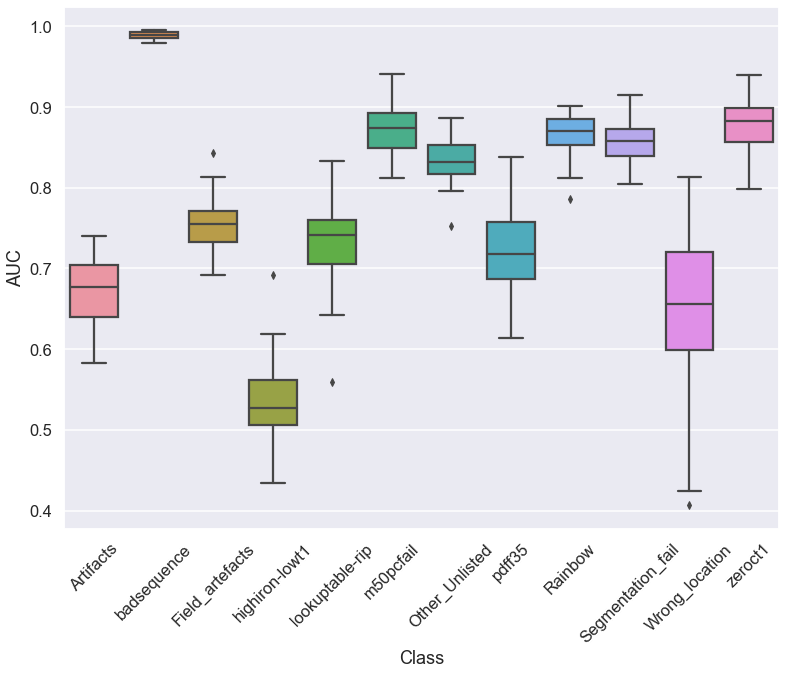

In [50]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

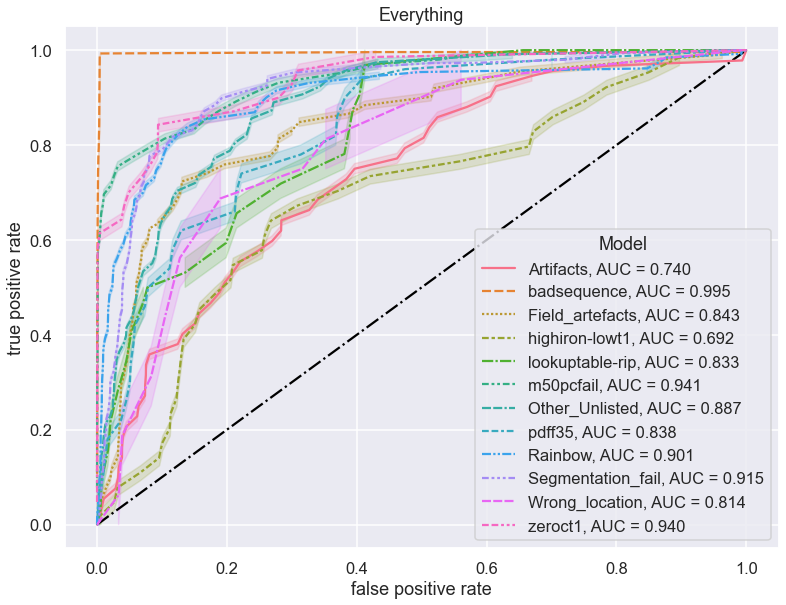

In [51]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [53]:
# Save Models
saveDir = "./models/MLP/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    torch.save(clfDict[name]["Classifier"].state_dict(),os.path.join(saveDir,name,"classifier.pt"))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [55]:
from torch.optim import Adam
from sklearn.model_selection import RepeatedStratifiedKFold
x0, y0 = ownDataset

x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:-errLength]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = MLP(X.shape[1],1)
        device = torch.device("cuda:0")
        clf = clf.to(device)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)

        X_train = X_train.float()
        y_train = y_train.float()

        X_val = X_train[int(0.8*X_train.shape[0]):,:]
        y_val = y_train[int(0.8*y_train.shape[0]):]

        X_train = X_train[:int(0.8*X_train.shape[0]),:]
        y_train = y_train[:int(0.8*y_train.shape[0])]

        batches = np.arange(0,X_train.shape[0],10)
        batches_Val = np.arange(0,X_val.shape[0],10)

        optimiser = Adam(clf.parameters(),lr=1e-4)
        critertion = nn.BCEWithLogitsLoss()
        critertion.to(device)

        numEpochs = 10
        lowestLoss = 10000000000000000000.0
        for nE in range(numEpochs):
            clf.train()
            for i,num in enumerate(batches[1:]):
                inputBatch = X_train[batches[i]:num,:]
                outputGT = y_train[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                optimiser.zero_grad()

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                loss.backward()

                optimiser.step()

            clf.eval()
            with torch.no_grad():
                valLoss = 0.0
                for i,num in enumerate(batches_Val[1:]):
                    inputBatch = X_val[batches[i]:num,:]
                    outputGT = y_val[batches[i]:num]
                    outputGT.unsqueeze_(1)

                    inputBatch = inputBatch.to(device)
                    outputGT = outputGT.to(device)

                    outputBatch = clf(inputBatch)

                    loss = critertion(outputBatch,outputGT)

                    valLoss += loss.item()

                valLoss /= X_val.shape[0]

                if valLoss < lowestLoss:
                    lowestLoss = valLoss
                    bestClf = copy.deepcopy(clf)

        with torch.no_grad():
            bestClf.eval()
            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            X_test = X_test.float()
            y_test = y_test.float()

            batches = np.arange(0,X_test.shape[0],100)
            sig = nn.Sigmoid().to(device)
            pred = np.zeros(y_test.shape)

            for i,num in enumerate(batches[1:]):
                inputBatch = X_test[batches[i]:num,:]

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = bestClf(inputBatch)
                outputBatch = sig(outputBatch)

                outputBatch = outputBatch.cpu().numpy()

                pred[batches[i]:num] = outputBatch[:,0]

            fpr,tpr,thresh = roc_curve(y_test,pred)
            auc_score = roc_auc_score(y_test,pred)
            avgAUC[name].append(auc_score)

            if topAUC[name] < auc_score:
                topAUC[name] = auc_score

                clfDict[name]["Classifier"] = bestClf
                clfDict[name]["X_train"] = X_train
                clfDict[name]["y_train"] = y_train
                clfDict[name]["X_test"] = X_test
                clfDict[name]["y_test"] = y_test

                metricsDict[name]["AUC"] = auc_score
                metricsDict[name]["FPR"] = fpr
                metricsDict[name]["TPR"] = tpr

        cnt +=1


[599/600]

In [56]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.565168     0.988381         0.750666        0.526204   
std     0.038747     0.004404         0.033944        0.045383   
min     0.463712     0.978554         0.641018        0.434404   
25%     0.544043     0.984796         0.731787        0.500432   
50%     0.562158     0.988753         0.753262        0.526387   
75%     0.590831     0.992407         0.773398        0.549725   
max     0.657915     0.995135         0.816130        0.674354   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.738222   0.593158        0.546750   0.673870   0.831804   
std           0.070387   0.041324        0.036729   0.046764   0.028062   
min           0.571507   0.465538        0.465478   0.555134   0.759219   
25%           0.685326   0.562

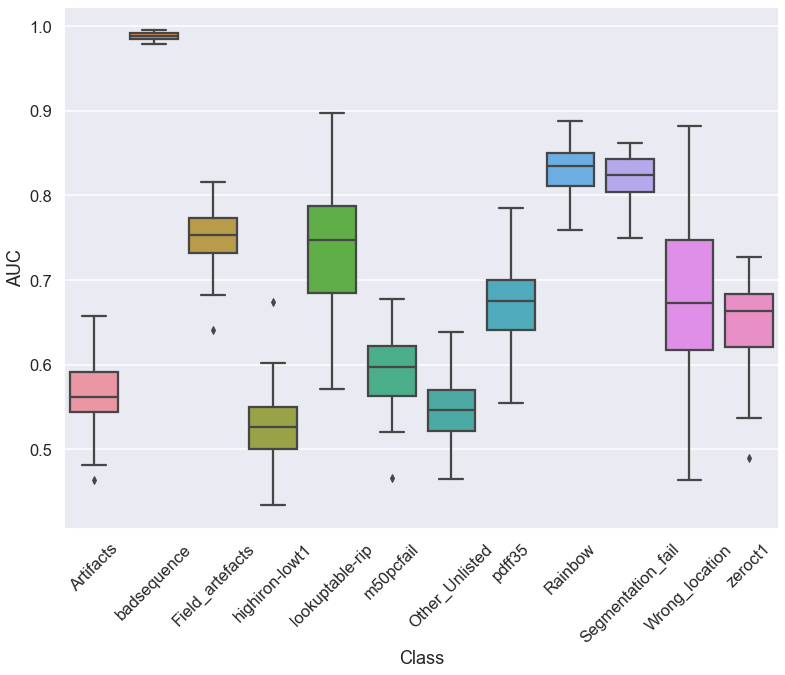

In [57]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

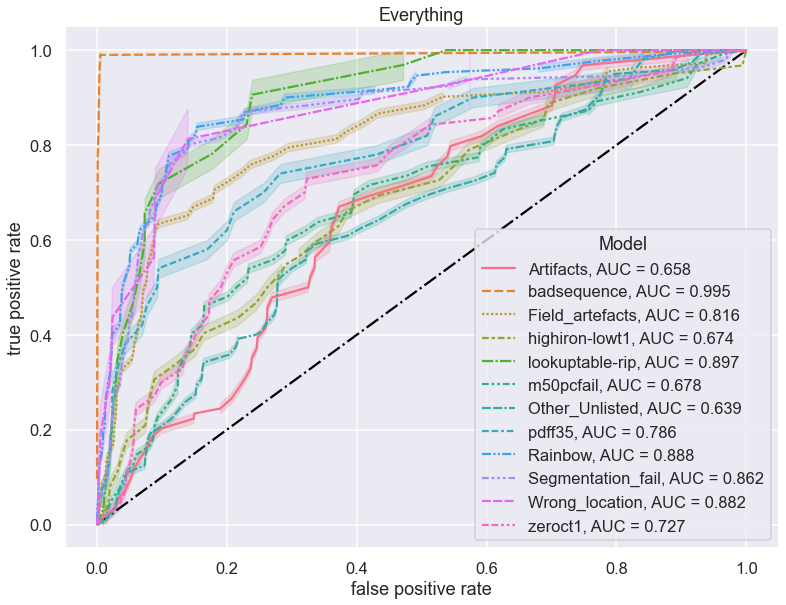

In [58]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Meta and Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [60]:
saveDir = "./models/MLP/Meta_BBoxes/"


if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    torch.save(clfDict[name]["Classifier"].state_dict(),os.path.join(saveDir,name,"classifier.pt"))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [32]:
from torch.optim import Adam
from sklearn.model_selection import RepeatedStratifiedKFold
x0, y0 = ownDataset

x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:-(errLength+bBoxesLength)]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = MLP(X.shape[1],1)
        device = torch.device("cuda:0")
        clf = clf.to(device)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)

        X_train = X_train.float()
        y_train = y_train.float()

        X_val = X_train[int(0.8*X_train.shape[0]):,:]
        y_val = y_train[int(0.8*y_train.shape[0]):]

        X_train = X_train[:int(0.8*X_train.shape[0]),:]
        y_train = y_train[:int(0.8*y_train.shape[0])]

        batches = np.arange(0,X_train.shape[0],10)
        batches_Val = np.arange(0,X_val.shape[0],10)

        optimiser = Adam(clf.parameters(),lr=1e-4)
        critertion = nn.BCEWithLogitsLoss()
        critertion.to(device)

        numEpochs = 10
        lowestLoss = 10000000000000000000.0
        for nE in range(numEpochs):
            clf.train()
            for i,num in enumerate(batches[1:]):
                inputBatch = X_train[batches[i]:num,:]
                outputGT = y_train[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                optimiser.zero_grad()

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                loss.backward()

                optimiser.step()

            clf.eval()
            with torch.no_grad():
                valLoss = 0.0
                for i,num in enumerate(batches_Val[1:]):
                    inputBatch = X_val[batches[i]:num,:]
                    outputGT = y_val[batches[i]:num]
                    outputGT.unsqueeze_(1)

                    inputBatch = inputBatch.to(device)
                    outputGT = outputGT.to(device)

                    outputBatch = clf(inputBatch)

                    loss = critertion(outputBatch,outputGT)

                    valLoss += loss.item()

                valLoss /= X_val.shape[0]

                if valLoss < lowestLoss:
                    lowestLoss = valLoss
                    bestClf = copy.deepcopy(clf)

        with torch.no_grad():
            bestClf.eval()
            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            X_test = X_test.float()
            y_test = y_test.float()

            batches = np.arange(0,X_test.shape[0],100)
            sig = nn.Sigmoid().to(device)
            pred = np.zeros(y_test.shape)

            for i,num in enumerate(batches[1:]):
                inputBatch = X_test[batches[i]:num,:]

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = bestClf(inputBatch)
                outputBatch = sig(outputBatch)

                outputBatch = outputBatch.cpu().numpy()

                pred[batches[i]:num] = outputBatch[:,0]

            fpr,tpr,thresh = roc_curve(y_test,pred)
            auc_score = roc_auc_score(y_test,pred)
            avgAUC[name].append(auc_score)

            if topAUC[name] < auc_score:
                topAUC[name] = auc_score

                clfDict[name]["Classifier"] = bestClf
                clfDict[name]["X_train"] = X_train
                clfDict[name]["y_train"] = y_train
                clfDict[name]["X_test"] = X_test
                clfDict[name]["y_test"] = y_test

                metricsDict[name]["AUC"] = auc_score
                metricsDict[name]["FPR"] = fpr
                metricsDict[name]["TPR"] = tpr

        cnt +=1



[599/600]

In [33]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.556097     0.988440         0.751977        0.532721   
std     0.037283     0.004395         0.033131        0.052681   
min     0.478940     0.978682         0.675786        0.401922   
25%     0.532270     0.984942         0.735500        0.495768   
50%     0.551357     0.988786         0.750354        0.537512   
75%     0.583691     0.992431         0.773346        0.576136   
max     0.650099     0.995241         0.820363        0.626712   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.754246   0.584743        0.525967   0.666566   0.833505   
std           0.059585   0.041047        0.039365   0.057301   0.021843   
min           0.561426   0.497265        0.411535   0.527582   0.781849   
25%           0.723703   0.553

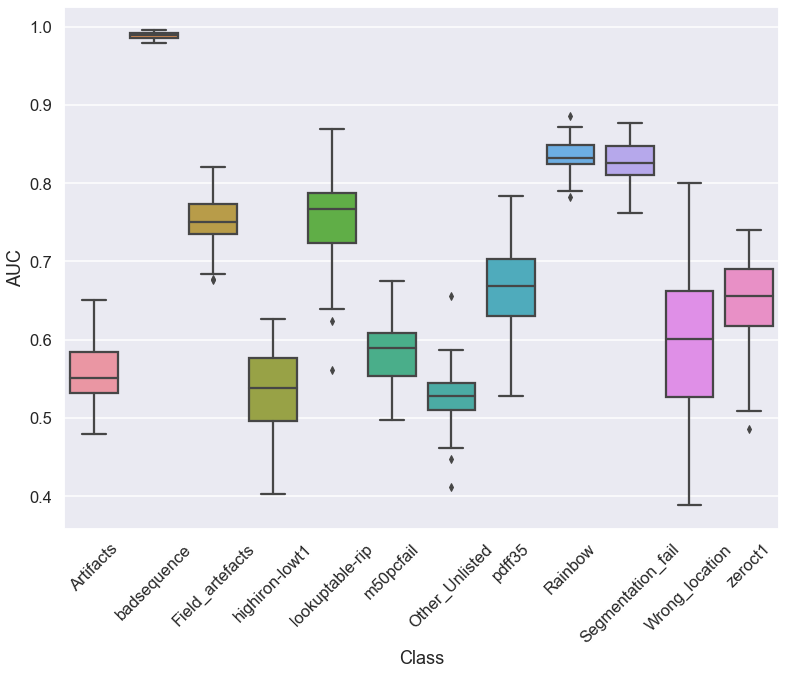

In [36]:
sns.set_theme("talk")
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

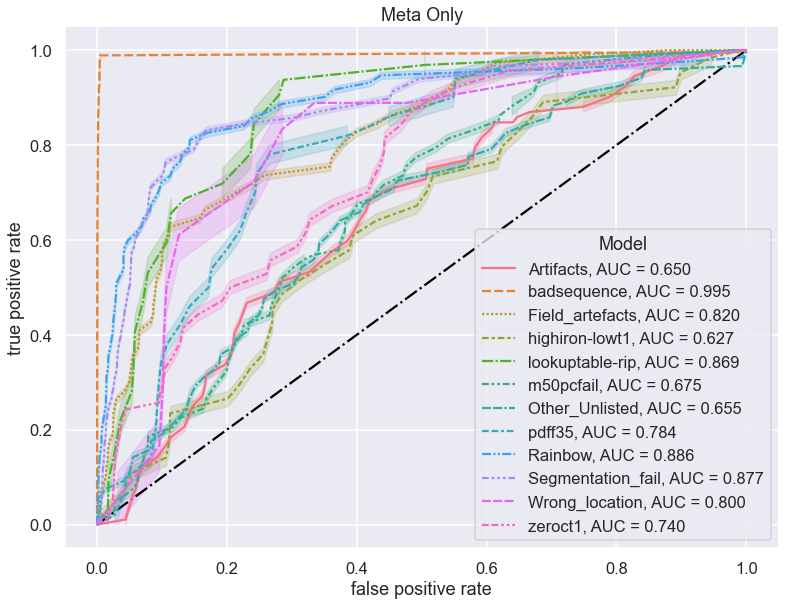

In [35]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [37]:
# Save Models
saveDir = "./models/MLP/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    torch.save(clfDict[name]["Classifier"].state_dict(),os.path.join(saveDir,name,"classifier.pt"))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [38]:
from torch.optim import Adam
from sklearn.model_selection import RepeatedStratifiedKFold
x0, y0 = ownDataset

x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,-errLength:]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = MLP(X.shape[1],1)
        device = torch.device("cuda:0")
        clf = clf.to(device)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)

        X_train = X_train.float()
        y_train = y_train.float()

        X_val = X_train[int(0.8*X_train.shape[0]):,:]
        y_val = y_train[int(0.8*y_train.shape[0]):]

        X_train = X_train[:int(0.8*X_train.shape[0]),:]
        y_train = y_train[:int(0.8*y_train.shape[0])]

        batches = np.arange(0,X_train.shape[0],10)
        batches_Val = np.arange(0,X_val.shape[0],10)

        optimiser = Adam(clf.parameters(),lr=1e-4)
        critertion = nn.BCEWithLogitsLoss()
        critertion.to(device)

        numEpochs = 10
        lowestLoss = 10000000000000000000.0
        for nE in range(numEpochs):
            clf.train()
            for i,num in enumerate(batches[1:]):
                inputBatch = X_train[batches[i]:num,:]
                outputGT = y_train[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                optimiser.zero_grad()

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                loss.backward()

                optimiser.step()

            clf.eval()
            with torch.no_grad():
                valLoss = 0.0
                for i,num in enumerate(batches_Val[1:]):
                    inputBatch = X_val[batches[i]:num,:]
                    outputGT = y_val[batches[i]:num]
                    outputGT.unsqueeze_(1)

                    inputBatch = inputBatch.to(device)
                    outputGT = outputGT.to(device)

                    outputBatch = clf(inputBatch)

                    loss = critertion(outputBatch,outputGT)

                    valLoss += loss.item()

                valLoss /= X_val.shape[0]

                if valLoss < lowestLoss:
                    lowestLoss = valLoss
                    bestClf = copy.deepcopy(clf)

        with torch.no_grad():
            bestClf.eval()
            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            X_test = X_test.float()
            y_test = y_test.float()

            batches = np.arange(0,X_test.shape[0],100)
            sig = nn.Sigmoid().to(device)
            pred = np.zeros(y_test.shape)

            for i,num in enumerate(batches[1:]):
                inputBatch = X_test[batches[i]:num,:]

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = bestClf(inputBatch)
                outputBatch = sig(outputBatch)

                outputBatch = outputBatch.cpu().numpy()

                pred[batches[i]:num] = outputBatch[:,0]

            fpr,tpr,thresh = roc_curve(y_test,pred)
            auc_score = roc_auc_score(y_test,pred)
            avgAUC[name].append(auc_score)

            if topAUC[name] < auc_score:
                topAUC[name] = auc_score

                clfDict[name]["Classifier"] = bestClf
                clfDict[name]["X_train"] = X_train
                clfDict[name]["y_train"] = y_train
                clfDict[name]["X_test"] = X_test
                clfDict[name]["y_test"] = y_test

                metricsDict[name]["AUC"] = auc_score
                metricsDict[name]["FPR"] = fpr
                metricsDict[name]["TPR"] = tpr

        cnt +=1


[599/600]

In [39]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.668168     0.986502         0.746442        0.522667   
std     0.039019     0.004383         0.037598        0.053789   
min     0.574973     0.976005         0.634905        0.417984   
25%     0.644973     0.983161         0.731085        0.478167   
50%     0.669261     0.986843         0.751606        0.527459   
75%     0.696255     0.990343         0.770343        0.556927   
max     0.747845     0.993966         0.813681        0.644314   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.727203   0.848030        0.838276   0.702763   0.862483   
std           0.066654   0.031121        0.029411   0.043271   0.022653   
min           0.508686   0.773908        0.772320   0.608438   0.807713   
25%           0.693129   0.827

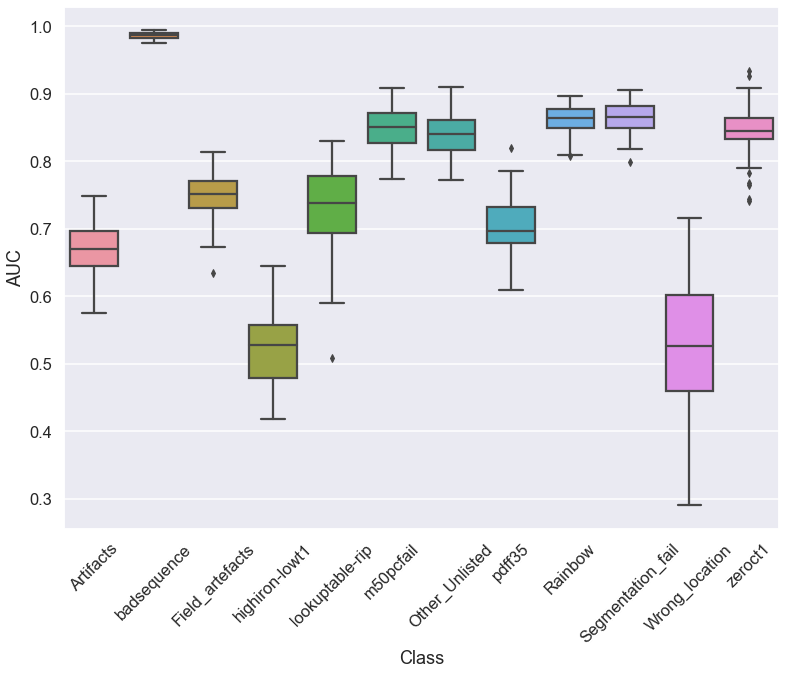

In [40]:
sns.set_theme("talk")
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

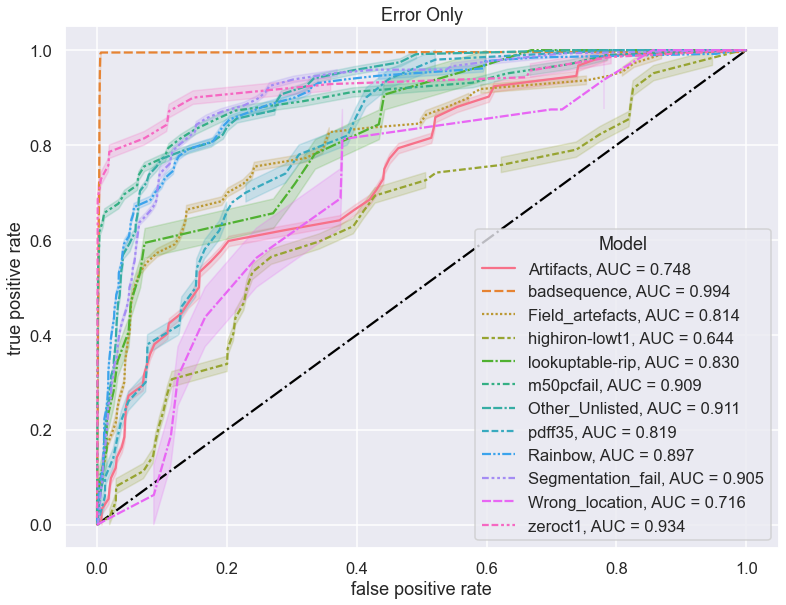

In [41]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [42]:
# Save Models
saveDir = "./models/MLP/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    torch.save(clfDict[name]["Classifier"].state_dict(),os.path.join(saveDir,name,"classifier.pt"))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [43]:
from torch.optim import Adam
from sklearn.model_selection import RepeatedStratifiedKFold
x0, y0 = ownDataset

x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,-(errLength+bBoxesLength):]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = MLP(X.shape[1],1)
        device = torch.device("cuda:0")
        clf = clf.to(device)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)

        X_train = X_train.float()
        y_train = y_train.float()

        X_val = X_train[int(0.8*X_train.shape[0]):,:]
        y_val = y_train[int(0.8*y_train.shape[0]):]

        X_train = X_train[:int(0.8*X_train.shape[0]),:]
        y_train = y_train[:int(0.8*y_train.shape[0])]

        batches = np.arange(0,X_train.shape[0],10)
        batches_Val = np.arange(0,X_val.shape[0],10)

        optimiser = Adam(clf.parameters(),lr=1e-4)
        critertion = nn.BCEWithLogitsLoss()
        critertion.to(device)

        numEpochs = 10
        lowestLoss = 10000000000000000000.0
        for nE in range(numEpochs):
            clf.train()
            for i,num in enumerate(batches[1:]):
                inputBatch = X_train[batches[i]:num,:]
                outputGT = y_train[batches[i]:num]
                outputGT.unsqueeze_(1)

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                optimiser.zero_grad()

                outputBatch = clf(inputBatch)

                loss = critertion(outputBatch,outputGT)

                loss.backward()

                optimiser.step()

            clf.eval()
            with torch.no_grad():
                valLoss = 0.0
                for i,num in enumerate(batches_Val[1:]):
                    inputBatch = X_val[batches[i]:num,:]
                    outputGT = y_val[batches[i]:num]
                    outputGT.unsqueeze_(1)

                    inputBatch = inputBatch.to(device)
                    outputGT = outputGT.to(device)

                    outputBatch = clf(inputBatch)

                    loss = critertion(outputBatch,outputGT)

                    valLoss += loss.item()

                valLoss /= X_val.shape[0]

                if valLoss < lowestLoss:
                    lowestLoss = valLoss
                    bestClf = copy.deepcopy(clf)

        with torch.no_grad():
            bestClf.eval()
            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            X_test = X_test.float()
            y_test = y_test.float()

            batches = np.arange(0,X_test.shape[0],100)
            sig = nn.Sigmoid().to(device)
            pred = np.zeros(y_test.shape)

            for i,num in enumerate(batches[1:]):
                inputBatch = X_test[batches[i]:num,:]

                inputBatch = inputBatch.to(device)
                outputGT = outputGT.to(device)

                outputBatch = bestClf(inputBatch)
                outputBatch = sig(outputBatch)

                outputBatch = outputBatch.cpu().numpy()

                pred[batches[i]:num] = outputBatch[:,0]

            fpr,tpr,thresh = roc_curve(y_test,pred)
            auc_score = roc_auc_score(y_test,pred)
            avgAUC[name].append(auc_score)

            if topAUC[name] < auc_score:
                topAUC[name] = auc_score

                clfDict[name]["Classifier"] = bestClf
                clfDict[name]["X_train"] = X_train
                clfDict[name]["y_train"] = y_train
                clfDict[name]["X_test"] = X_test
                clfDict[name]["y_test"] = y_test

                metricsDict[name]["AUC"] = auc_score
                metricsDict[name]["FPR"] = fpr
                metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [44]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.655821     0.986435         0.748685        0.520647   
std     0.039310     0.004383         0.033273        0.054745   
min     0.563304     0.976841         0.671637        0.419838   
25%     0.627459     0.983177         0.729678        0.486295   
50%     0.653209     0.986612         0.750279        0.523888   
75%     0.683170     0.990342         0.762692        0.565171   
max     0.733347     0.993880         0.824352        0.641737   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.723859   0.855092        0.844781   0.701716   0.866061   
std           0.057666   0.031925        0.026514   0.054286   0.025040   
min           0.570413   0.794612        0.782916   0.572718   0.809649   
25%           0.691642   0.831

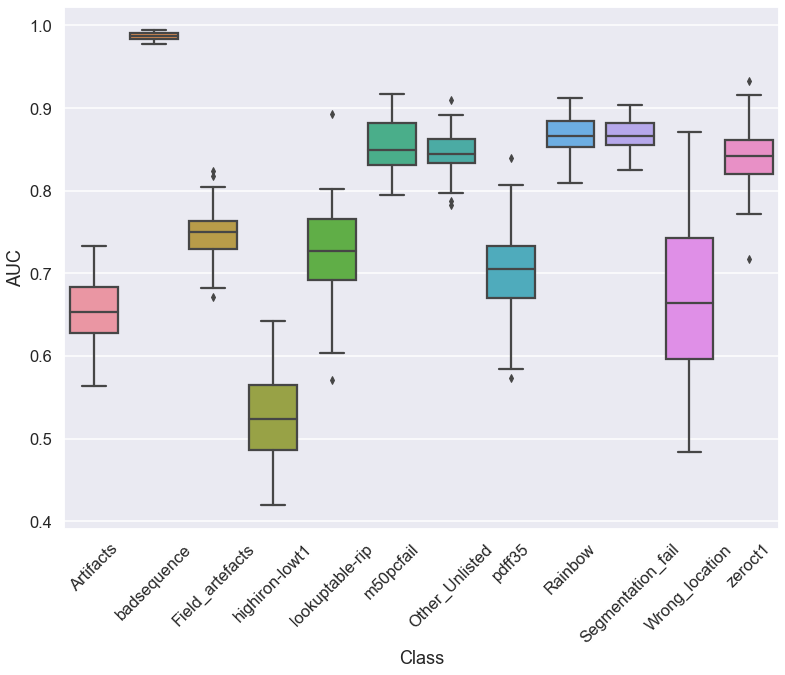

In [45]:
sns.set_theme("talk")
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

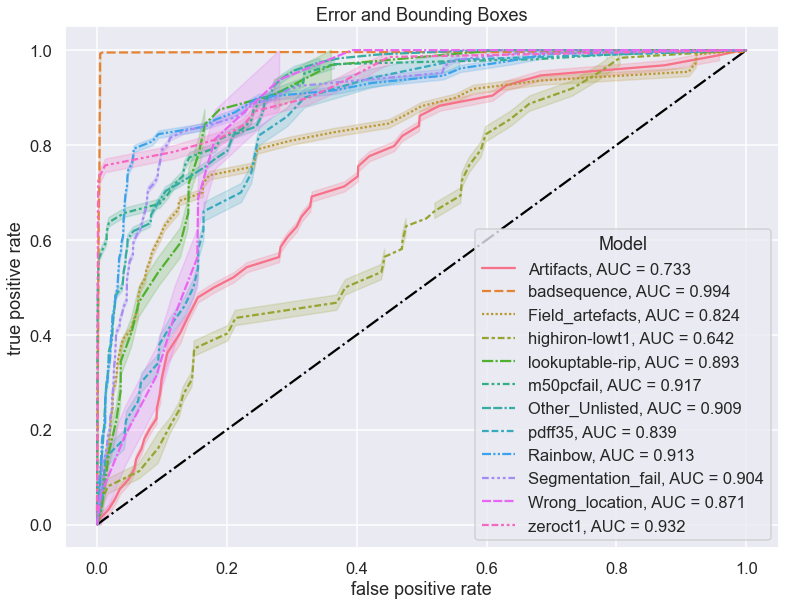

In [46]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Error and Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [47]:
# Save Models
saveDir = "./models/MLP/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    torch.save(clfDict[name]["Classifier"].state_dict(),os.path.join(saveDir,name,"classifier.pt"))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

Error_Only
All_Meta
Error_BBoxes
Meta_Only
Meta_BBoxes


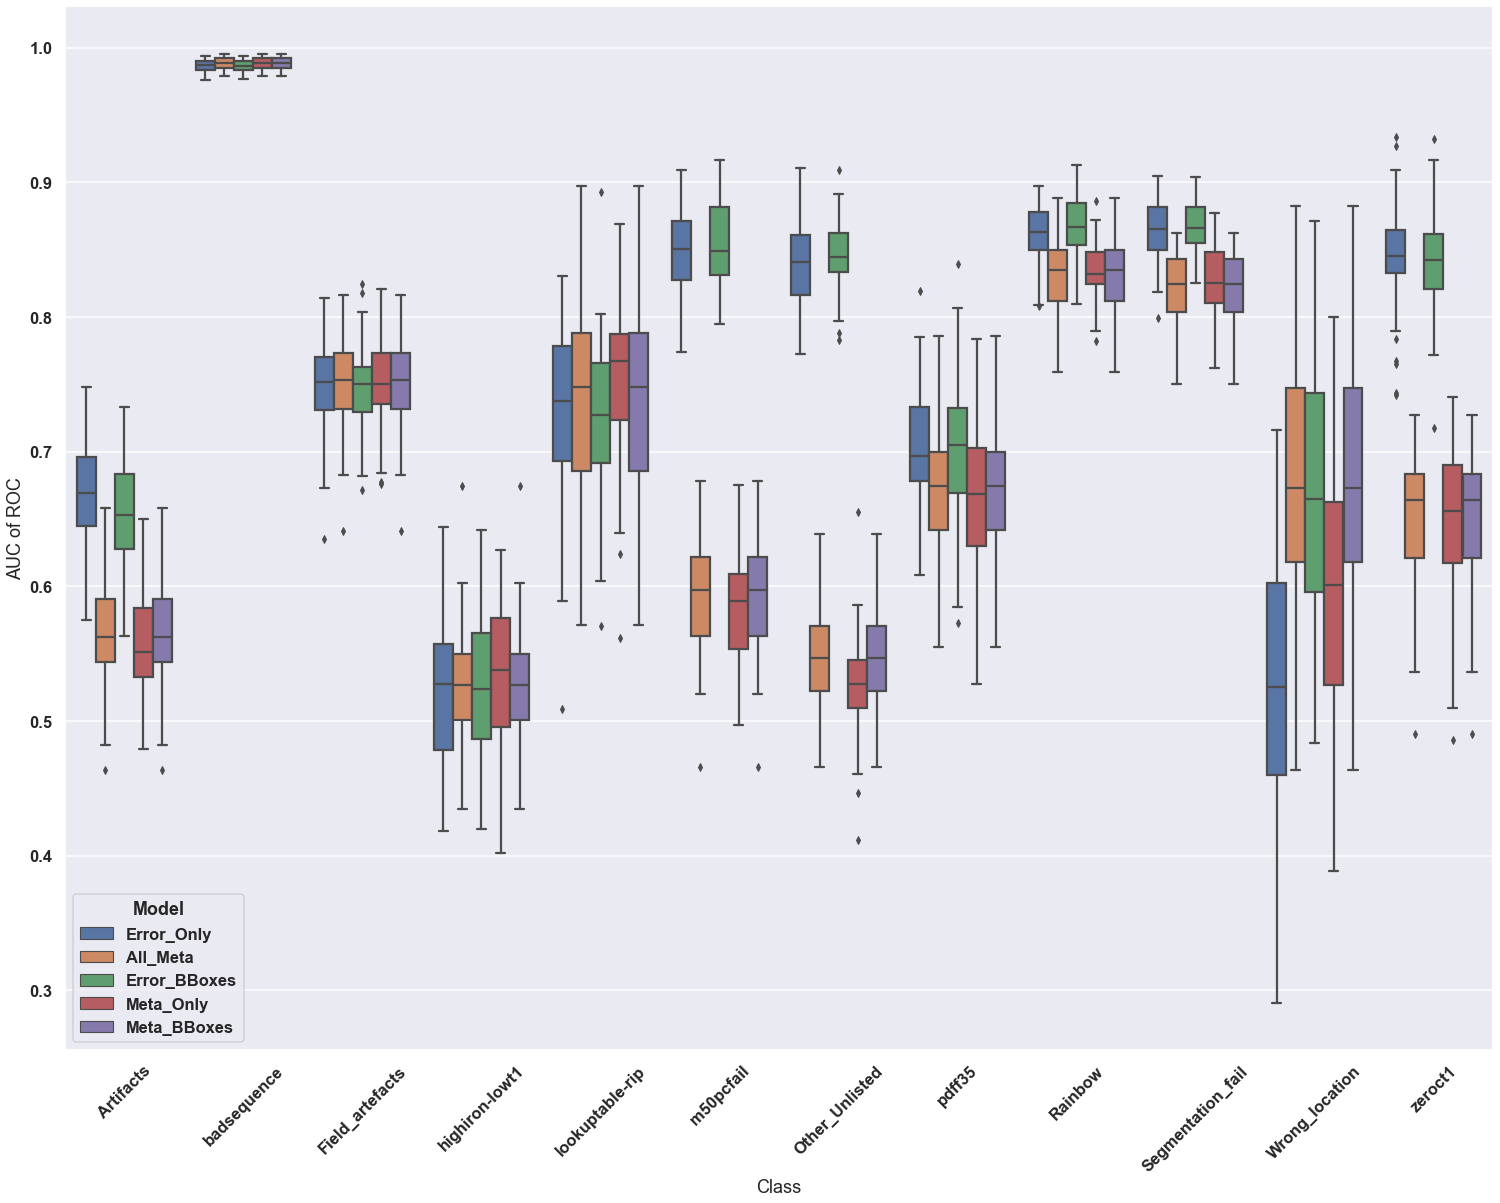

In [23]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.rcParams["figure.figsize"] = [6.4*4,4.8*4]
sns.set_theme("talk")
sns.set_style("darkgrid")

loadDir = "./models/MLP/"
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]

classList = []
aucList = []
modelList = []

for fol in rfList:
    print(fol)

    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)

    for k in tagNames:
        metricsClass = metrics[k]
        for k1 in metricsClass.keys():
            aucList.append(metricsClass[k1])
            classList.append(k)
            modelList.append(fol)

fullDict = {"Model":modelList,"Class":classList,"AUC":aucList}
df = pd.DataFrame(fullDict)

plt.figure()
sns.boxplot(data=df,x="Class",y="AUC",hue="Model")
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

## Start from here to plot ROC curves

All_Meta


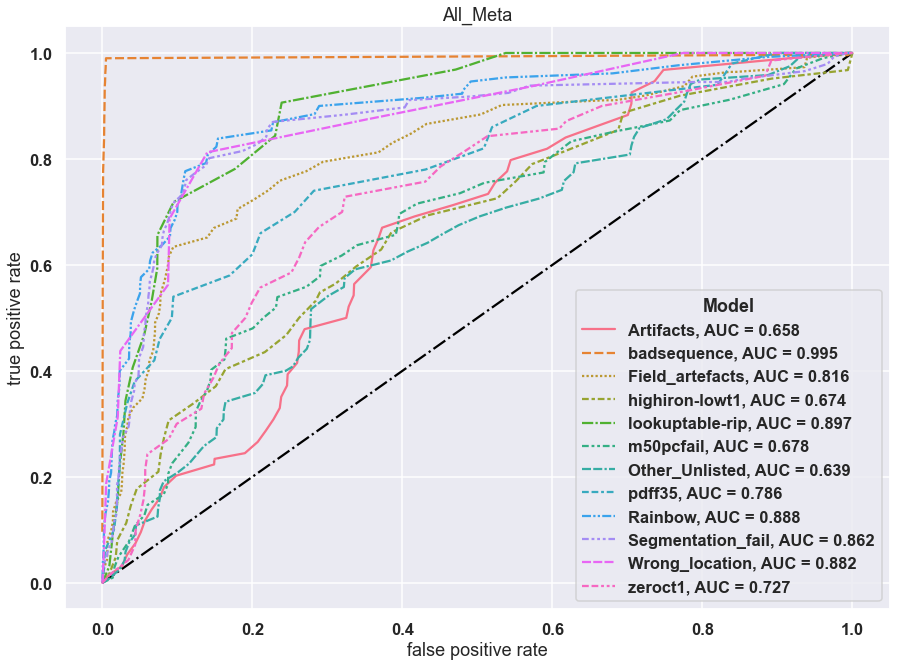

Error_BBoxes


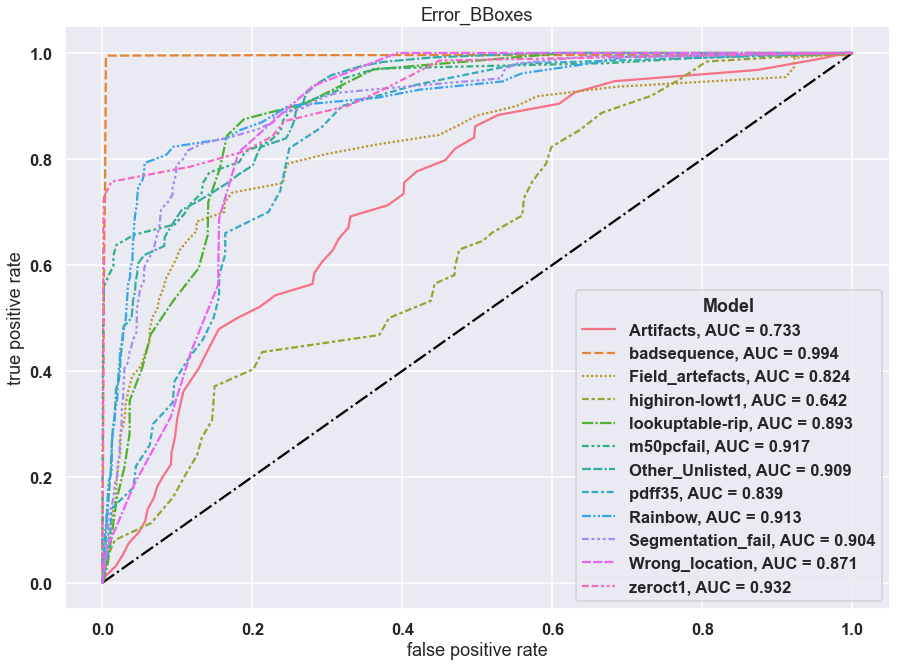

Error_Only


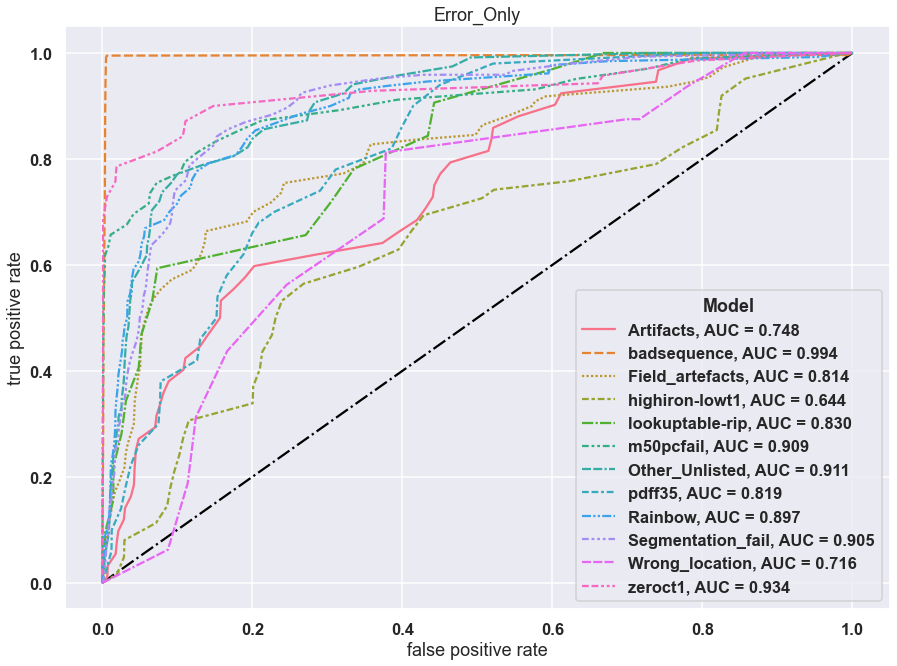

Meta_BBoxes


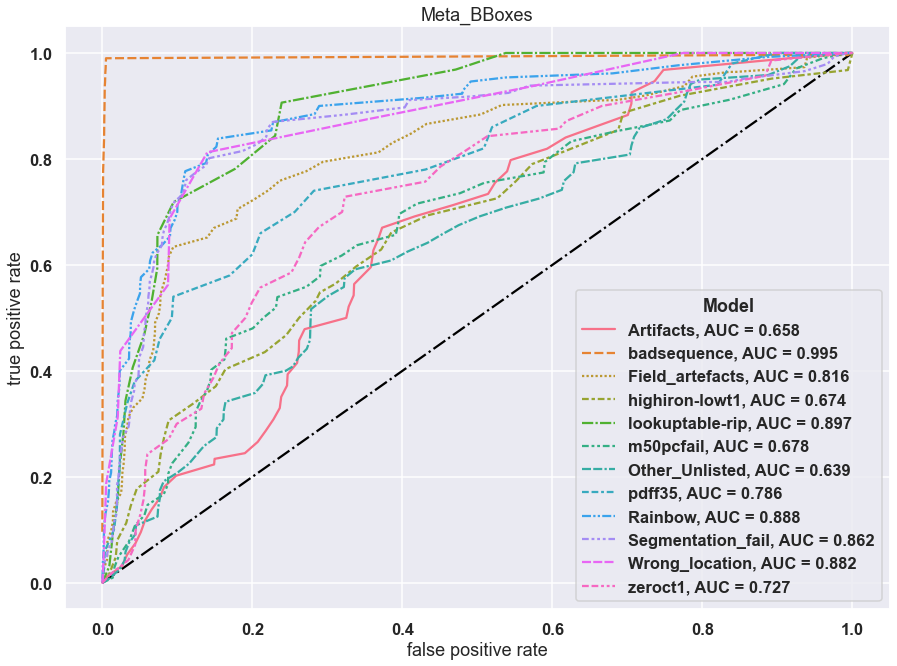

Meta_Only


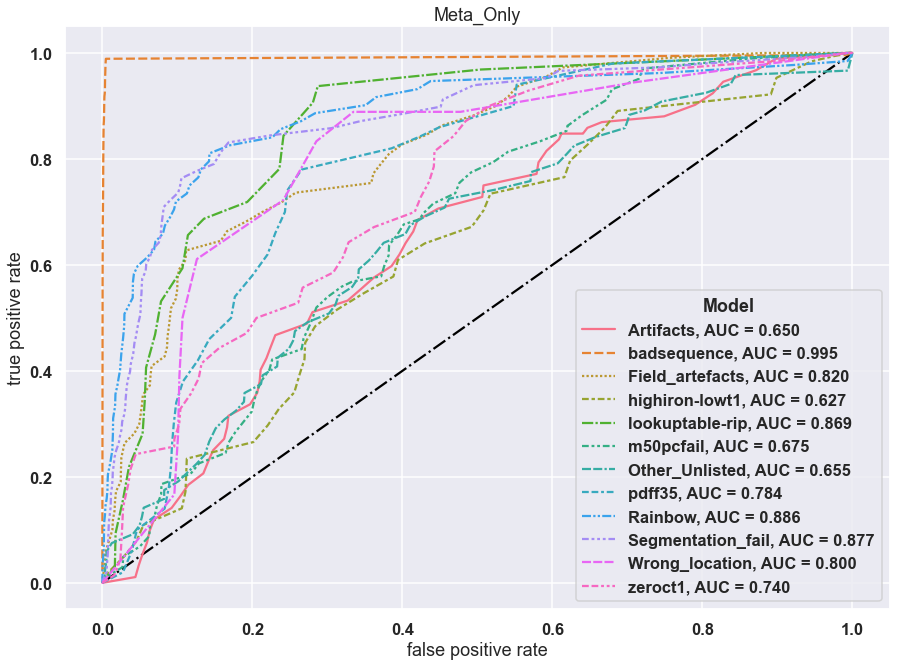

In [1]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.rcParams["figure.figsize"] = [6.4*2,4.8*2]
sns.set_theme("talk")
sns.set_style("darkgrid")

loadDir = "./models/MLP/"
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]


for fol in rfList:
        print(fol)
        with open(os.path.join(loadDir,fol,"roc_values.json")) as f:
                df = pd.read_json(f)


        sns.set_theme(context="talk")
        sns.set_style("darkgrid")
        plt.figure()
        plt.title(fol)
        sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
        sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
        plt.tight_layout()
        plt.savefig("./Figures/ROC_MLP_{}.png".format(fol))
        plt.show()

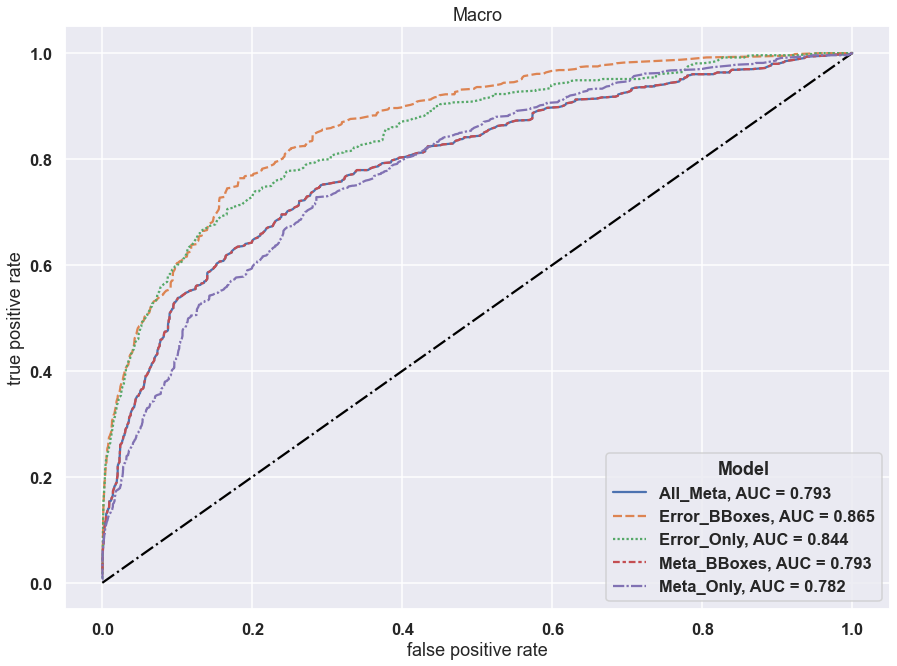

In [15]:
import pickle
import pandas
from sklearn.metrics import roc_auc_score, roc_curve, auc

modelsArrMicro = []
modelsArrMacro = []

fprArrMicro = []
tprArrMicro = []

fprArrMacro = []
tprArrMacro = []

for fol in rfList:
    saveDir = "./models/MLP/{}/".format(fol)

    fprDict = {}
    tprDict = {}
    rocDict = {}

    df = pd.read_json("{}roc_values.json".format(saveDir))
    for i,name in enumerate(tagNames):
        subDf = df.loc[df["Model"].str.contains(name)]
        fprDict[name] = subDf["false positive rate"]
        tprDict[name] = subDf["true positive rate"]
        rocDict[name] = auc(fprDict[name],tprDict[name])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for name in tagNames:
        mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

    # Finally average it and compute AUC
    mean_tpr /= len(tagNames)
    auc_score = auc(all_fpr,mean_tpr)
    event = ["{}, AUC = {:.3f}".format("{}".format(fol),auc_score)]*(all_fpr.shape[0])

    modelsArrMacro.extend(event)
    fprArrMacro.extend(all_fpr)
    tprArrMacro.extend(mean_tpr)

    # fpr,tpr,_ = roc_curve(y_test.ravel(),pred.ravel())
    # auc_score = roc_auc_score(y_test.ravel(),pred.ravel())

    # event = ["{}, AUC = {:.3f}".format("{}".format(fol),auc_score)]*(fpr.shape[0])

    # modelsArrMicro.extend(event)
    # fprArrMicro.extend(fpr)
    # tprArrMicro.extend(tpr)


event = np.array(modelsArrMacro)
fpr = np.array(fprArrMacro)
tpr = np.array(tprArrMacro)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Macro")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.tight_layout()
plt.savefig("./Figures/ROC_MLP_MACRO.png")
plt.show()

# event = np.array(modelsArrMicro)
# fpr = np.array(fprArrMicro)
# tpr = np.array(tprArrMicro)
# df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

# plt.figure()
# plt.title("Micro")
# sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
# sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
# plt.savefig("./Figures/ROC_MLP_MICRO.png")
# plt.show()